## Importing the libraries

In [2]:
# GPU 加速版 TensorFlow 從 2.12 開始，不需要自己另外安裝 CUDA/cuDNN，pip版會自帶，需要驅動夠新即可！（NVIDIA Driver >= 450.xx）
!pip install tensorflow==2.12
!pip install matplotlib numpy pandas


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.12.0'

## Loading and preprocessing the dataset
- 從 TensorFlow 內建的資料集中，載入 MNIST 數字手寫資料集的「訓練資料」部分

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [5]:
# 查看每張圖片維度
print(X_train.shape) # 60000 張圖片，每張圖28*28
print(y_train.shape)

(60000, 28, 28)
(60000,)


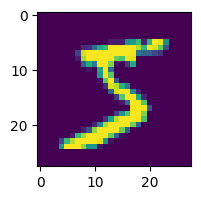

In [6]:
# 取出單張圖片
import matplotlib.pyplot as plt

plt.figure(figsize=(2,2))  # 設定畫布大小，(寬, 高)，單位是英吋
plt.imshow(X_train[0])
plt.show()

- 深度學習的 CNN 模型（比如 DCGAN）要吃4D資料（圖片高、寬、通道數） => 轉reshape
- 把資料型態轉成 float32，因為之後進神經網路計算，會希望用浮點數（float）而不是原本的整數（uint8）。

In [7]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [8]:
# 查看原本像素值範圍
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

## data Standardized()
有兩種方式：
- 方式01：tf.keras.layers.Rescaling
  - 從 TensorFlow 2.6 以後官方推薦的方法！
  - 直接加一層在模型最前面，會自動做標準化，超級乾淨！

```python
from tensorflow.keras.layers import Rescaling
rescale_layer = Rescaling(scale=1./127.5, offset=-1) # 加一層 Rescaling 把數值從 [0,255] 正規化到 [-1,1]
```

- 方式02：
  - 這個不是轉成 -1 ~ 1，而是讓每張圖片變成：平均值是 0、標準差是 1

```python
import tensorflow as tf

X_train = tf.image.per_image_standardization(X_train)
```

In [9]:
from tensorflow.keras.layers import Rescaling

rescale_layer = Rescaling(1./127.5, offset=-1)

X_train = rescale_layer(X_train) # 用 rescale_layer 處理

2025-04-28 15:32:03.300568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 15:32:03.300888: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# 設定 Buffer 和 Batch Size
buffer_size = 60000 # 是全部資料的數量（60000筆）
batch_size = 256 # 每次拿幾筆資料進去訓練，通常設定 batch_size = 256、128、64 等常見數字

# 轉換成 TensorFlow Dataset：把 numpy array 轉成 TensorFlow 的 Dataset 格式，方便後面拿資料訓練
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [11]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

##  DCGAN的 Generator（生成器）模型

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [12]:
def build_generator():
    network = tf.keras.Sequential() # 建立一個順序型的神經網路

    network.add(layers.Dense(units=7*7*256, use_bias=False, input_shape=(100,)))
    # 期望輸出 7×7×256 = 12544 個神經元 ➔ 為了之後可以 reshape 成一個 7x7 的小小圖片，並且有 256個通道
    # 不加偏置項（bias），因為後面會有 BatchNormalization（BatchNorm會自己處理偏移問題）。
    # 輸入是一個 100維的向量

    network.add(layers.BatchNormalization())
    # Batch Normalization 層：讓輸出的資料標準化成 平均值0、標準差1，加速模型訓練、穩定收斂

    network.add(layers.LeakyReLU())
    # LeakyReLU 激活函數：跟 ReLU 很像，但對於負數部分不是直接設成0，而是給一個小小斜率（例如0.2）。
    # 避免「死神經」（神經元不再更新）

    network.add(layers.Reshape((7,7,256))) 
    # 把剛剛 12544 維的向量，重塑成一個形狀是 7×7×256 的小立方體（小圖片）
    # 希望後面能用卷積操作 (Conv2DTranspose) 來放大這個小圖片。

    ##### 第一次轉置卷積（調特徵數，不放大）######
    network.add(layers.Conv2DTranspose(filters=128, kernel_size=(5,5), padding='same', use_bias=False))
    # 轉置卷積層（有時又叫「反卷積層」
    # 這一層要學習 128 個特徵圖（feature maps）
    # padding='same'：代表卷積時輸出大小不變（保持7x7）。

    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    ##### 第二次轉置卷積（開始放大尺寸）######
    network.add(layers.Conv2DTranspose(filters=64, kernel_size=(5,5), padding='same', strides=(2,2), use_bias=False))
    # 設成 (2,2) ➔ 讓圖從 7x7 放大到 14x14！
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    ##### 第三次轉置卷積（放大到28x28，生成最終圖片）######
    network.add(layers.Conv2DTranspose(filters=1, kernel_size=(5,5), padding='same', strides=(2,2), use_bias=True, activation='tanh'))
    # filters=1：這層只有一個通道，因為我們要生成灰階圖片。
    # 繼續使用5x5濾波器
    # strides=(2,2)：再放大一次，讓 14x14 ➔ 28x28。
    # activation='tanh'：使用 tanh，把輸出值限制在 [-1, 1]，符合資料標準化後的範圍

    network.summary() # 印出網路結構
    return network

generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [13]:
print(generator.input)
print(generator.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name='dense_input'), name='dense_input', description="created by layer 'dense_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), name='conv2d_transpose_2/Tanh:0', description="created by layer 'conv2d_transpose_2'")


### 製造隨機噪聲來餵給 Generator
- Generator 要從一個隨機噪聲（Noise Vector）去「想像」出一張假的圖片
- GAN不是直接給圖，它是從無到有生成的。
- 這個噪聲就是「創作靈感」啦！（不然 Generator 都沒靈感怎麼畫圖XD）

In [14]:
# 創造一個長度是100的隨機亂數向量，就是 DCGAN 的 Generator 要吃的東西
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.7451495 , -0.20478016, -0.3776187 ,  0.35397094, -0.81424314,
         1.4398834 , -1.3104447 , -0.27728567,  0.05576651,  0.7985706 ,
         1.1394254 , -0.5686352 , -0.67105806, -1.2619956 ,  1.664235  ,
        -2.2196343 ,  0.83680505,  1.4650173 , -0.5107319 , -1.9835262 ,
         0.372117  ,  0.36646312, -1.724092  , -0.74328583, -0.47174698,
        -0.8187597 ,  0.11189617,  0.20853078, -0.5016957 , -0.280536  ,
         1.2839919 ,  0.8322274 ,  0.91118157, -1.3032984 ,  0.19316788,
        -0.0748798 , -1.22422   ,  1.3572233 ,  1.1264218 , -0.57732904,
        -0.35953268,  0.21649563,  0.14786848,  0.55405045, -1.7453936 ,
        -0.13212025,  0.0931502 ,  1.3893565 , -0.31791005, -0.9252585 ,
        -2.088558  , -0.15548965,  1.2585212 ,  1.6764551 , -1.6103531 ,
        -0.27169856, -1.7406347 , -1.4495041 ,  0.03219678,  0.69310796,
        -1.1074347 , -0.10590471,  0.9194603 ,  0.4810676 ,  0.30101874,
 

### 有 noise 了，可以馬上拿去丟給你的 Generator 啦！

In [15]:
generated_image = generator(noise, training=False)

(1, 28, 28, 1)


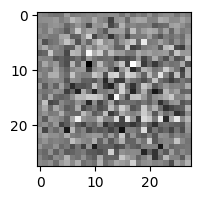

In [16]:
print(generated_image.shape)


import matplotlib.pyplot as plt
plt.figure(figsize=(2,2))  # 設定畫布大小，(寬, 高)，單位是英吋
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

##  DCGAN的 discriminator（判斷器）模型

- Dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
- Conv2d x Conv2dTranspose: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d

In [17]:
def build_discriminator():
    network = tf.keras.Sequential()
    network = tf.keras.Sequential() # 建立一個順序型的神經網路

    ##### 第一層卷積層（Conv2D）##### 
    network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
    # filters=64：要學 64 張特徵圖（Feature Maps），像是學邊緣、角落這些特徵。
    # strides=(2,2)：每次移動 2 格 → 讓圖變小一半（從28x28 ➔ 14x14）。
    # kernel_size=(5,5)：用 5x5 大小的小視窗掃過圖片。
    # padding='same'：掃完後保持圖片大小一致。
    # input_shape=[28,28,1]：輸入的是 28×28 的灰階圖（1個通道）。

    network.add(layers.LeakyReLU())
    # 讓神經網路學到非線性特徵。
    # 比普通的 ReLU 更好，因為負數不會直接死掉，而是有小小斜率。

    network.add(layers.Dropout(0.3)) # 隨機丟掉 30% 的神經元，防止過擬合（讓模型更穩定）。


    ##### 第二層卷積層（再壓縮一次）##### 
    network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
    # 再加一個卷積層，這次學 128 張特徵圖
    # 同樣使用 5x5 小視窗，每次移動2格。
    # 把 14x14 的特徵圖繼續壓縮成 7x7。    
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3)) # 隨機丟掉 30% 的神經元，防止過擬合（讓模型更穩定）。

    ##### Flatten（平鋪）##### 
    network.add(layers.Flatten()) # 把 7x7x128 的資料展平成一條長長的向量，因為下面要接 Dense（全連接層），需要一維資料。

	##### Dense（輸出1個數）##### 
    network.add(layers.Dense(1))

    network.summary()
    return network

discriminator = build_discriminator()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [18]:
print(discriminator.input)
print(discriminator.output)


KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/BiasAdd:0', description="created by layer 'dense_1'")


In [19]:
# 把生成器做出來的假圖片，拿去丟到判別器
# training=False：代表現在是測試/推論，不是訓練
discriminator(generated_image, training = False) # 輸出一個數字 => 原始logit，它可以是正的、負的、小的、大的都可能

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00266892]], dtype=float32)>

In [20]:
# Sigmoid 函數可以把一個「任意數字」轉成介於【0到1】之間的機率值。
# 代表「這張圖是真的的機率」是多少。
tf.sigmoid(0.00079025)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5001976>

## Error calculation

In [21]:
# 建立二元交叉熵損失函數(這個函數用來量化分類結果到底有多錯。)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# from_logits=True，代表：丟進來的分數（discriminator的輸出）是logit（生分數），不是0~1之間的機率！
# 這樣 TensorFlow 會自動先幫你做 sigmoid 再算 loss

In [22]:
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

### 定義 Discriminator Loss

In [23]:
def discriminator_loss(expected_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 定義 Generator Loss

In [24]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 最後定義 Optimizer
- 給 生成器 和 判別器各自一個 Adam Optimizer。
- 這樣他們在訓練時，可以自己更新自己的參數。
- 設定學習率（learning rate）為 0.00001 ➔ 很小，因為GAN很容易不穩，學太快會爆炸。

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Training the GAN and visualizing the results

In [26]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [27]:
epochs = 100
noise_dimension = 100
number_of_images = 16

In [28]:
@tf.function # 把下面這個 train 函數「加速」成 TensorFlow 的 計算圖（Graph）。計算圖可以讓 TensorFlow 自動優化，跑得比純 Python 快很多。
def train(images):
	noise = tf.random.normal([batch_size, noise_dimension]) # 產生隨機噪聲
	# 隨機生成一堆亂數，當作「生成器」的輸入。
	# 每個批次有 batch_size 筆、每筆 noise_dimension=100 維的向量。
	with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # 開兩個 GradientTape(兩卷錄影帶)
		# gen_tape 負責記錄「生成器」的運算過程
		# disc_tape 負責記錄「判別器」的運算過程
		generated_images = generator(noise, training=True) # 生成假圖片

		# 判別真假圖片
		expected_output = discriminator(images, training=True)
		fake_output = discriminator(generated_images, training=True)

		# 算 Loss
		gen_loss = generator_loss(fake_output) # 生成器的目標是「騙倒判別器」。
		disc_loss = discriminator_loss(expected_output, fake_output) # 判別器的目標是「正確辨識真假」。

		# 算梯度
		# 分別針對生成器、判別器的 Loss：算出每個參數需要怎麼微調（梯度）。
		generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
		discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)


		# 更新參數
		# 把剛剛的梯度套用回網路裡 ➔ 更新網路權重
		generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
		discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [29]:
tf.config.run_functions_eagerly(True)
# 打開 eager mode
# 預設 @tf.function 會把函數編譯成計算圖 (graph)，這樣快但難除錯
# 開啟 run_functions_eagerly(True) ➔ 讓 TensorFlow 每一行都即時執行，比較慢，但方便看錯誤訊息（適合開發&debug用）。

X_train_batch = X_train.as_numpy_iterator().next()
# X_train 本來是一個 tf.data.Dataset（可以一批一批拿資料）。
# .as_numpy_iterator()：把它變成一個可以像 Python 迴圈那樣拿資料的物件。
# .next()：拿出第一個 batch的資料。

train(X_train_batch)

2025-04-28 15:32:04.043789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [60000,28,28,1]
	 [[{{node Placeholder/_0}}]]
2025-04-28 15:32:04.044078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [60000,28,28,1]
	 [[{{node Placeholder/_0}}]]


In [30]:
# 測試生成器的噪聲：產生 number_of_images 個噪聲向量（每個長度是 noise_dimension，也就是 100 維）。
test_images = tf.random.normal([number_of_images, noise_dimension])
print(test_images.shape)

(16, 100)


### DCGAN 的完整訓練總流程

In [31]:
def train_gan(dataset, epochs, test_images):
    '''
    dataset：訓練資料（手寫數字圖）
    epochs：訓練多少回合
    test_images：固定的一組噪聲，用來觀察每個 epoch 生成出來的圖進步到哪
    '''
    for epoch in range(epochs):
        #print(epoch)
        for image_batch in dataset:
            #print(image_batch.shape)
            train(image_batch)

        print('Epoch: ', epoch + 1)
        generated_images = generator(test_images, training = False)
        fig = plt.figure(figsize = (10,10))
        for i in range(generated_images.shape[0]):
            plt.subplot(4,4,i + 1)
            plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.show()

In [32]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [35]:
!pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/kcwc1029/miniconda3/envs/gan/lib/python3.11/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [34]:
train_gan(X_train, epochs, test_images)

KeyboardInterrupt: 